#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем нужные библиотеки и загрузим данные

In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # визуализация
import seaborn as sns
from statsmodels.graphics import tsaplots # функция автокорреляции для временного ряда
import statsmodels.api as sm

from time import time

from statsmodels.tsa.seasonal import seasonal_decompose # тренды и сезонности временного ряда
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer  # метрики
from sklearn.preprocessing import StandardScaler # стандартизация данных

from sklearn.dummy import DummyRegressor  # константная модель
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor

plt.rcParams['figure.figsize'] = (10,5)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [66]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])

In [67]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


В первую очередь посмотрим общую информацию о данных

In [68]:
def data_describe(data):
    print('Общая информация:')
    data.info()
    print('Первые 5 строк:')
    display(data.head())
    print('Описание датафрейма:')
    display(data.describe())
    print('Пропуски:')
    display(data.isna().sum().sort_values(ascending=False))
    print('Дубликаты:')
    display(data.duplicated().sum())
    print('Уникальные значения:')
    display(data.nunique().sort_values())
    print('Разделим признаки на категориальные и числовые:')
    num_columns = []
    cat_columns = []
    for num, i in enumerate(data.columns):
        if pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
    print('Всего числовых признаков:', len(num_columns))
    print('Всего категориальных признаков:', len(cat_columns))

In [69]:
data_describe(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
Первые 5 строк:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Описание датафрейма:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропуски:


datetime      0
num_orders    0
dtype: int64

Дубликаты:


0

Уникальные значения:


num_orders       81
datetime      26496
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 1
Всего категориальных признаков: 0


In [70]:
df = df.set_index(pd.DatetimeIndex(df['datetime']))
df = df.drop('datetime', axis=1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные загружены с корректным типом данных, признак даты преобразован в индекс.

Проверим данные на монотонность

In [71]:
df.index.is_monotonic

True

Проведена проверка на хронологический порядок даты и времени - порядок соблюдён, данные отсортированы по дате

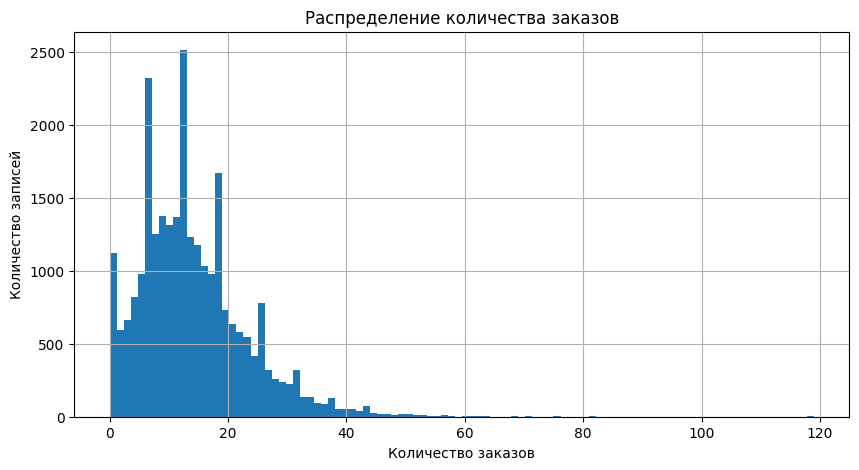

In [72]:
df.hist(bins=100)
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество записей')
plt.show()

Распредение выглядит нормально, но есть резко выбивающиеся значения. Возможно, есть какие-то тренды и сезонность в данных. Выясним это далее

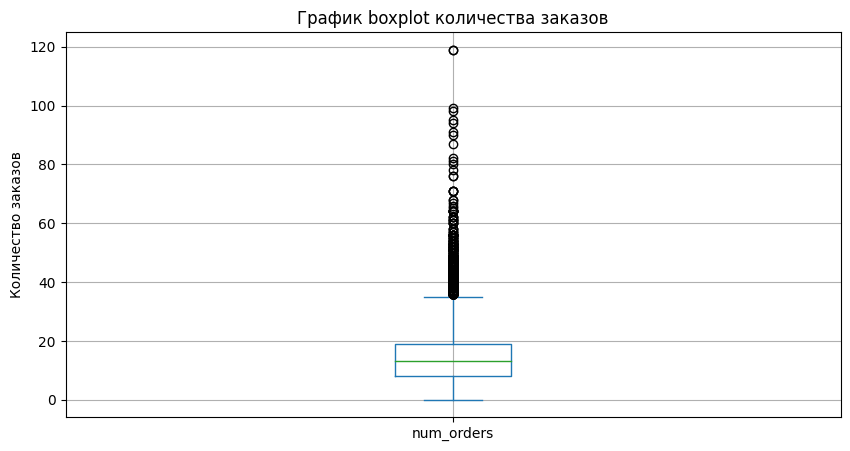

In [73]:
df.plot(kind='box', title='График boxplot количества заказов', grid=True)
plt.ylabel('Количество заказов')
plt.show()

**Выводы**
- исходный датафрейм содержит 26496 записей и 2 столбца, один из которых преобразован в индекс формата даты и времени, второй признак числовой
- данные отображают информацию о количестве заказов такси за полгода: начиная с 1 марта 2018 года и заканчивая 31 августа 2018 года
- пропуски и дубликаты отсутствуют
- у более 75% записей менее 20 заказов за 10 минут, минимум - отсутствие заказов, максимум - 119 заказов за 10 минут

## Анализ

Выполним ресемплирование по одному часу

In [74]:
print(df.shape)

df = df.resample('1H').sum()

print(df.head())
print(df.shape)

(26496, 1)
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
(4416, 1)


Признаков стало более чем в 6 раз меньше

Посмотрим на динамику по месяцам

            num_orders
datetime              
2018-03-31       42768
2018-04-30       45939
2018-05-31       54820
2018-06-30       59906
2018-07-31       74405
2018-08-31       94973


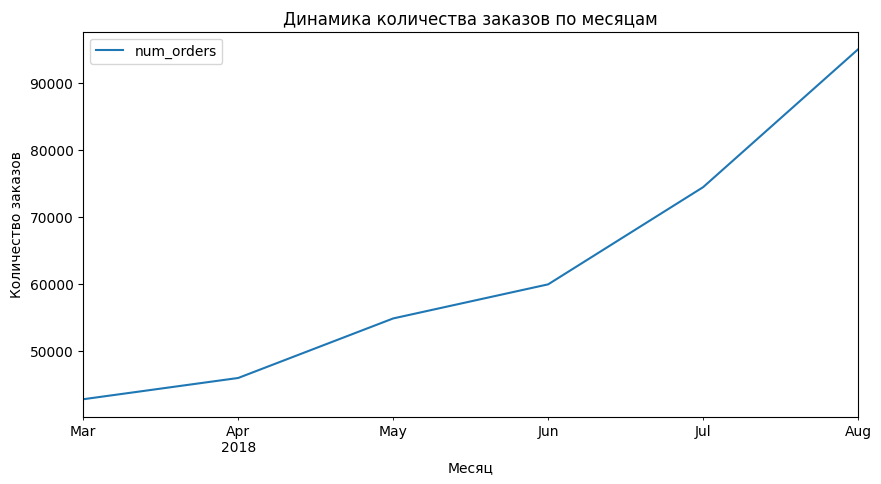

In [75]:
print(df.resample('1M').sum())

df.resample('1M').sum().plot()
plt.title('Динамика количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Наблюдаем стабильную восходящую динамику - с марта по август количество заказов постеренно увеличивается

Один из самых важных признаков в задаче временных рядов - "лаг" (значение предыдущего периода). Наша модель должна предсказывать значения, опираясь на предыдущие, соответственно эти признаки с отстающими значениями необходимо добавить к каждой записи. Вопрос в количестве таких "лагов". Особенно полезны будут те лаги, которые имеют высокую корреляцию с таргетом. Логично, что высокая корреляция будет при выраженной сезонности. Если у нас посуточная сезонность, то каждый час одних суток будет немного похож по динамике заказов на тот же час предыдущих суток (например, к 17:00 количество заказов увеличивается, далее пик к 00:00, а к 6:00 падает до минимума, и так каждый день). Значит, нам понадобится 24-й лаг, который будет отражать суточную сезонность. Если есть недельная сезонность, то по этой же причине нам будет очень важен 168-й лаг.

Посмотрим на значимость лагов по автокорреляции. Функция показывает, как признак коррелирует с предыдущими

In [76]:
sm.tsa.acf(df['num_orders'], nlags=168)

array([1.        , 0.62357649, 0.46452465, 0.32043529, 0.24814684,
       0.2298361 , 0.23748927, 0.29018382, 0.30808338, 0.26891539,
       0.26188927, 0.31567115, 0.33006991, 0.31139308, 0.2574396 ,
       0.23516873, 0.27119575, 0.25503531, 0.21005561, 0.19658396,
       0.2169681 , 0.26377549, 0.40118999, 0.5489739 , 0.68015266,
       0.54017251, 0.39280961, 0.25332671, 0.18845973, 0.19510941,
       0.19889152, 0.23756153, 0.2575079 , 0.22201394, 0.2293656 ,
       0.25716178, 0.27473205, 0.26812635, 0.22162156, 0.2229771 ,
       0.25324172, 0.24333172, 0.20142494, 0.20538926, 0.20078026,
       0.27240708, 0.40702608, 0.5488336 , 0.69846535, 0.54973745,
       0.41387317, 0.27432547, 0.21940934, 0.19815189, 0.22068542,
       0.25115349, 0.26326732, 0.23171646, 0.23596128, 0.27980554,
       0.29398248, 0.28433428, 0.24405117, 0.23635234, 0.26601626,
       0.24485174, 0.20444112, 0.19215833, 0.18966555, 0.25069191,
       0.3715838 , 0.52602112, 0.67117496, 0.52295393, 0.38133

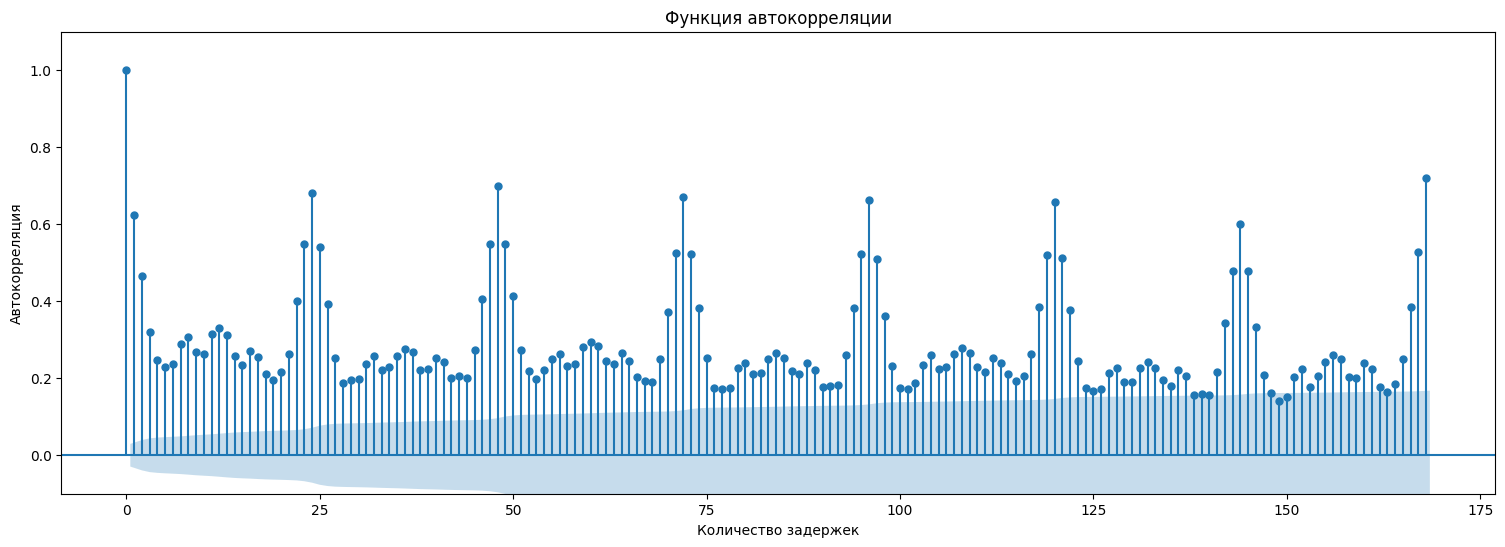

In [77]:
fig = tsaplots.plot_acf(df['num_orders'], lags=168, title='Функция автокорреляции')
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.xlabel('Количество задержек')
plt.ylabel('Автокорреляция')
plt.show()

График функции автокорреляции показывает наличие суточной сезонности - как минимум необходимо взять 24 лага. Хорошим вариантом с точки зрения качества моделей будет 168 лагов

Визуализируем график общего количества заказов по дням

In [78]:
df['date'] = pd.to_datetime(df.index.date)

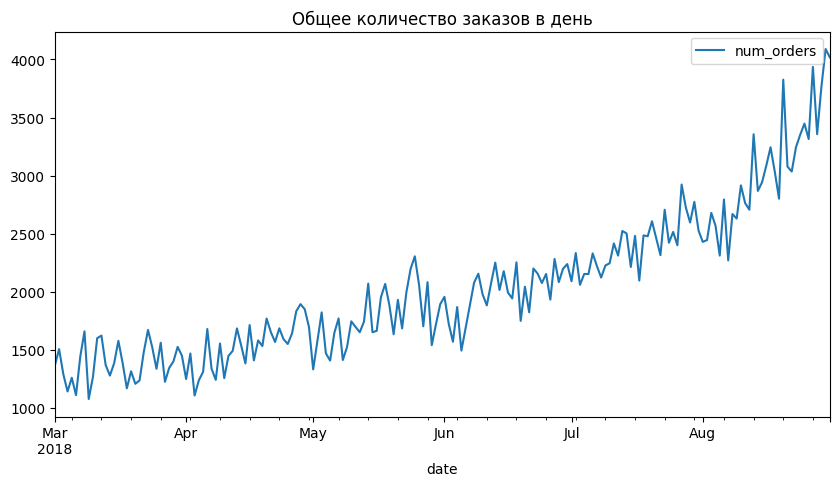

In [79]:
df.groupby('date')[['num_orders']].sum().plot()
plt.title('Общее количество заказов в день')
plt.show()

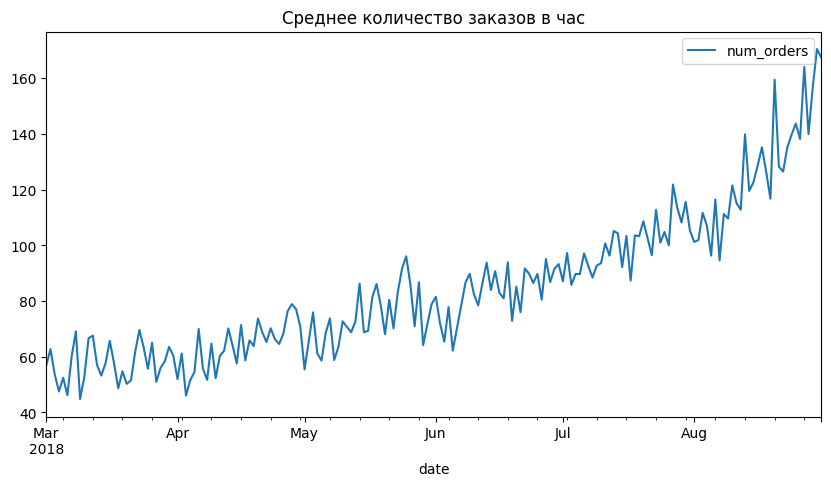

In [80]:
df.groupby('date')[['num_orders']].mean().plot()
plt.title('Среднее количество заказов в час')
plt.show()

Выясним, есть ли недельные зависимости в разные месяцы. Случайным образом выберем апрель и июль и сравним дни недели пиковых значений

<Figure size 2000x700 with 0 Axes>

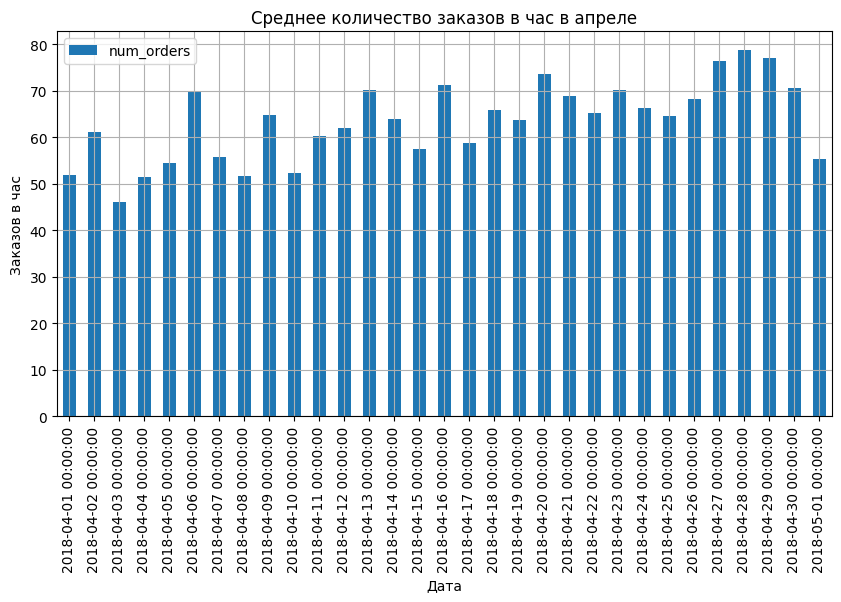

In [81]:
plt.figure(figsize=(20,7))

df['2018-04-01':'2018-05-01'].groupby('date')[['num_orders']].mean().plot(kind='bar')
plt.title('Среднее количество заказов в час в апреле')
plt.xlabel('Дата')
plt.ylabel('Заказов в час')
plt.grid(True)
plt.show()

<Figure size 2000x700 with 0 Axes>

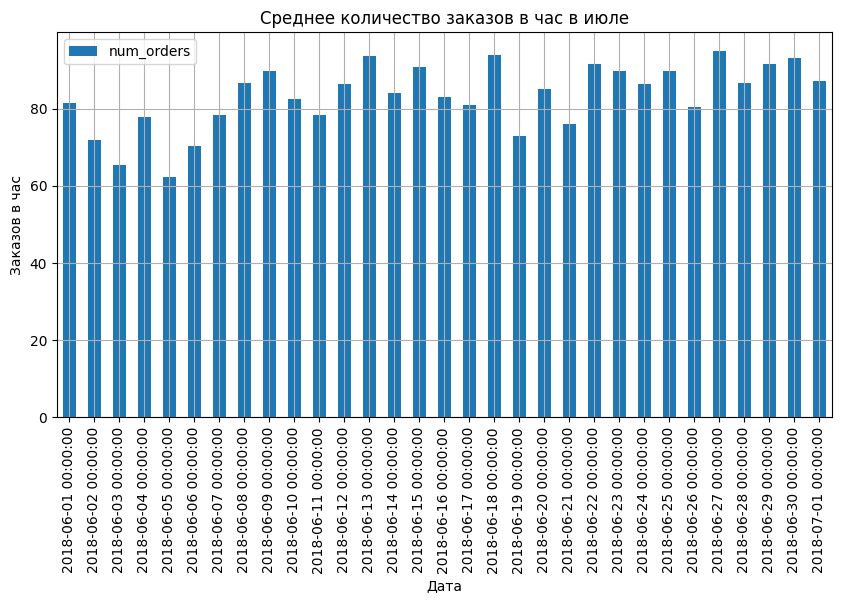

In [82]:
plt.figure(figsize=(20,7))

df['2018-06-01':'2018-07-01'].groupby('date')[['num_orders']].mean().plot(kind='bar')
plt.title('Среднее количество заказов в час в июле')
plt.xlabel('Дата')
plt.ylabel('Заказов в час')
plt.grid(True)
plt.show()

По графикам можно заметить, что в июне меньше всего заказов в час было в следующие числа: 5, 11, 19, 26. В апреле - 3, 10, 17, 24. Эти дни - вторники. Также наблюдаем пики по пятницам - среднее количество заказов в эти дни выше. Соответственно, есть основания полагать, что недельный тренд в нашем периоде существует

**Тренд и сезонность**

Проверим, присутствует ли в данных тренды и сезонные изменения количества заказов. Для этого воспользуемся функцией разбивки данных из модуля statsmodels - seasonal_decompose(). Графики сначала построим по всем данных, затем по данным августа (последнего месяца)

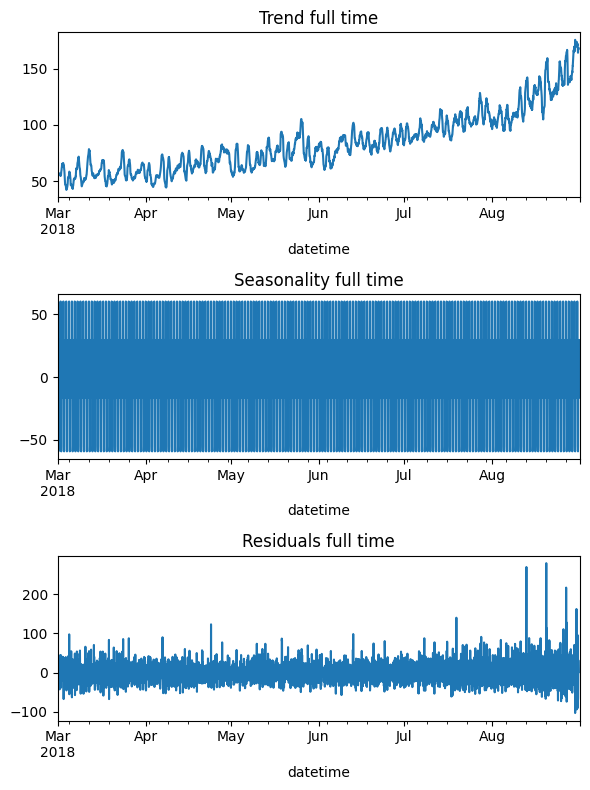

In [83]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend full time')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality full time')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals full time')
plt.tight_layout()

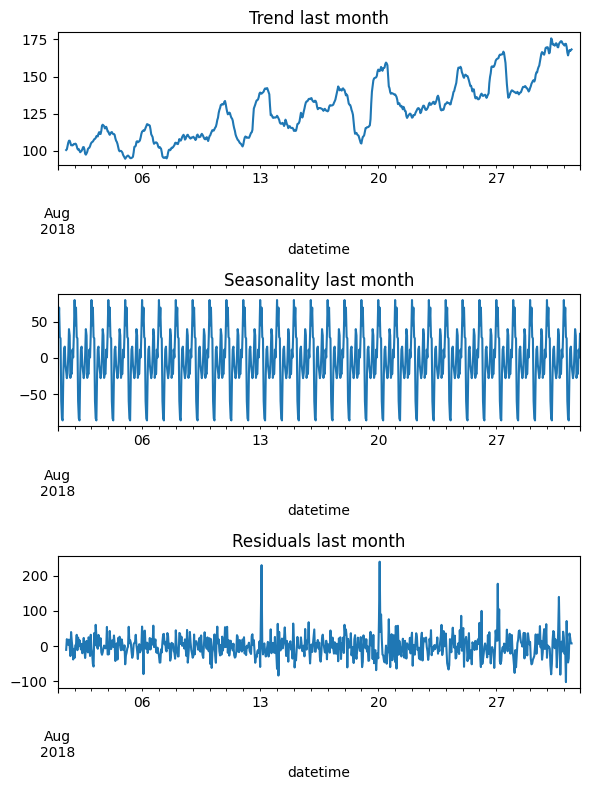

In [84]:
decomposed = seasonal_decompose(df['2018-08':'2018-08']['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend last month')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality last month')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals last month')
plt.tight_layout()

- по-прежнему виден положительный тренд как на всем временном промежутке, так и в последний изучаемый месяц (при чем рост очень стремительный)
- количество заказов увеличивается с течением времени
- в августе по дням имеются более выраженные пиковые значения и спады, разберем их подробнее
- в остатках есть выбивающиеся значения. Возможно, это связано с общим ростом количества рейсов в аэропортах в конкретные дни ввиду отдыха, личных поездок (праздники и т.п.), командировок и бизнес поездок (форумы и т.п.)

**Количество заказов и скользящие среднее**

Скользящее среднее как признак задаёт общий тренд временного ряда. Добавим в набор данных скользящее среднее для определения типа нашего временного ряда (стационарный/нестационарный)

In [85]:
df['rolling_mean'] = df['num_orders'].shift().rolling(5).mean()

<Figure size 1000x500 with 0 Axes>

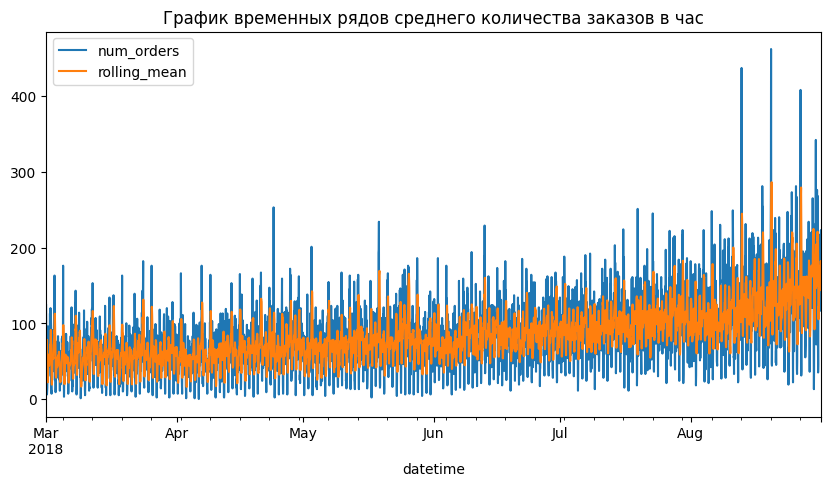

In [86]:
plt.figure()
df[['num_orders', 'rolling_mean']].plot(figsize=(10, 5))
plt.title('График временных рядов среднего количества заказов в час')
plt.show();

В целом по графику виден тренд роста количества заказов. С ним увеличивается как и скользящее среднее, так и скользящее стандартное отклонение, что свидетельствует о том, что временной ряд является нестационарным.

Прогнозировать значения таких рядов сложнее. Однако, как видно из графика, проблемы, присущие нестационарным рядам, начинают проявляться ближе к концу. До этого же, график вполне можно охарактеризовать как стационарный. Будем иметь ввиду, что конец временного промежутка может оказать влияние на качество прогноза

**Вывод перед добавлением новых признаков:**

Годовую сезонность на наших данных мы уловить не сможем, соответственно признак месяца нам не совсем важен. Наши календарные признаки подчеркивают суточную и недельную сезонности, то есть важными новыми признаками должны стать часы и дни недели. Потребуется к добавлению 168 «лагов»

**Добавление признаков**

Главная задача работы - предсказание и обучение моделей, для этого потребуется больше признаков. Добавим:

1. Календарные признаки:

- hour - час дня
- day - день месяца
- dayofweek - номер дня недели
- weekend - выходной день (0/1)
- daytime - часть суток: утро/день/вечер/ночь (0-3)
- day_orders - общее количество заказов в тот же час суток предыдущего дня (потребуется сдвиг на сутки)

2. «Отстающие значения» lag (предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться)

In [87]:
df_copy = df

In [88]:
def make_features(data, max_lag=168):
    # календарные признаки
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)

    daytime = {0: range(0, 7),
               1: range(7, 13),
               2: range(13, 19),
               3: range(19, 24)}

    def daytimes(x):
        for dt in daytime.keys():
            if x in daytime[dt]:
                return dt

    data['daytime'] = data['hour'].apply(daytimes)

    data['day_orders'] = data['num_orders'].shift(24)

    # отстающие значения
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    return data

In [89]:
df = make_features(df)
df.head()

,num_orders,date,rolling_mean,hour,day,dayofweek,weekend,daytime,day_orders,lag_1,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018-03-01,NaN,0,1,3,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018-03-01,NaN,1,1,3,0,0,NaN,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018-03-01,NaN,2,1,3,0,0,NaN,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018-03-01,NaN,3,1,3,0,0,NaN,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018-03-01,NaN,4,1,3,0,0,NaN,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на показатели статистики после добавления новых признаков:

In [59]:
lag_list = [f'lag_{i}' for i in range(1, 169)]

display(df.drop(columns=lag_list).describe())

,num_orders,rolling_mean,hour,day,dayofweek,weekend,daytime,day_orders
count,4416.000000,4411.000000,4416.00000,4416.000000,4416.000000,4416.000000,4416.00000,4392.000000
mean,84.422781,84.346316,11.50000,15.836957,3.005435,0.282609,1.37500,83.969262
std,45.023853,34.297233,6.92297,8.855229,1.990684,0.450319,1.11115,44.498432
min,0.000000,16.000000,0.00000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,54.000000,61.600000,5.75000,8.000000,1.000000,0.000000,0.00000,54.000000
50%,78.000000,78.800000,11.50000,16.000000,3.000000,0.000000,1.00000,78.000000
75%,107.000000,102.600000,17.25000,23.250000,5.000000,1.000000,2.00000,107.000000
max,462.000000,286.200000,23.00000,31.000000,6.000000,1.000000,3.00000,462.000000


Визуализируем, как зависит среднее число заказов от часа дня, дня недели, части суток и от того, выходной ли день

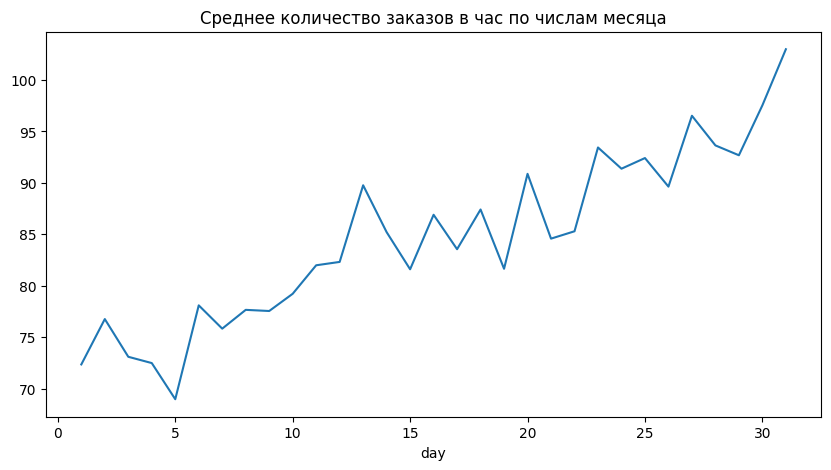

In [60]:
df.groupby('day')['num_orders'].mean().plot()
plt.title('Среднее количество заказов в час по числам месяца')
plt.show()

Интересное наблюдение - есть тренд на возрастание среднего количество заказов такси в час по календарным дням

In [61]:
df = df.drop('date', axis=1)

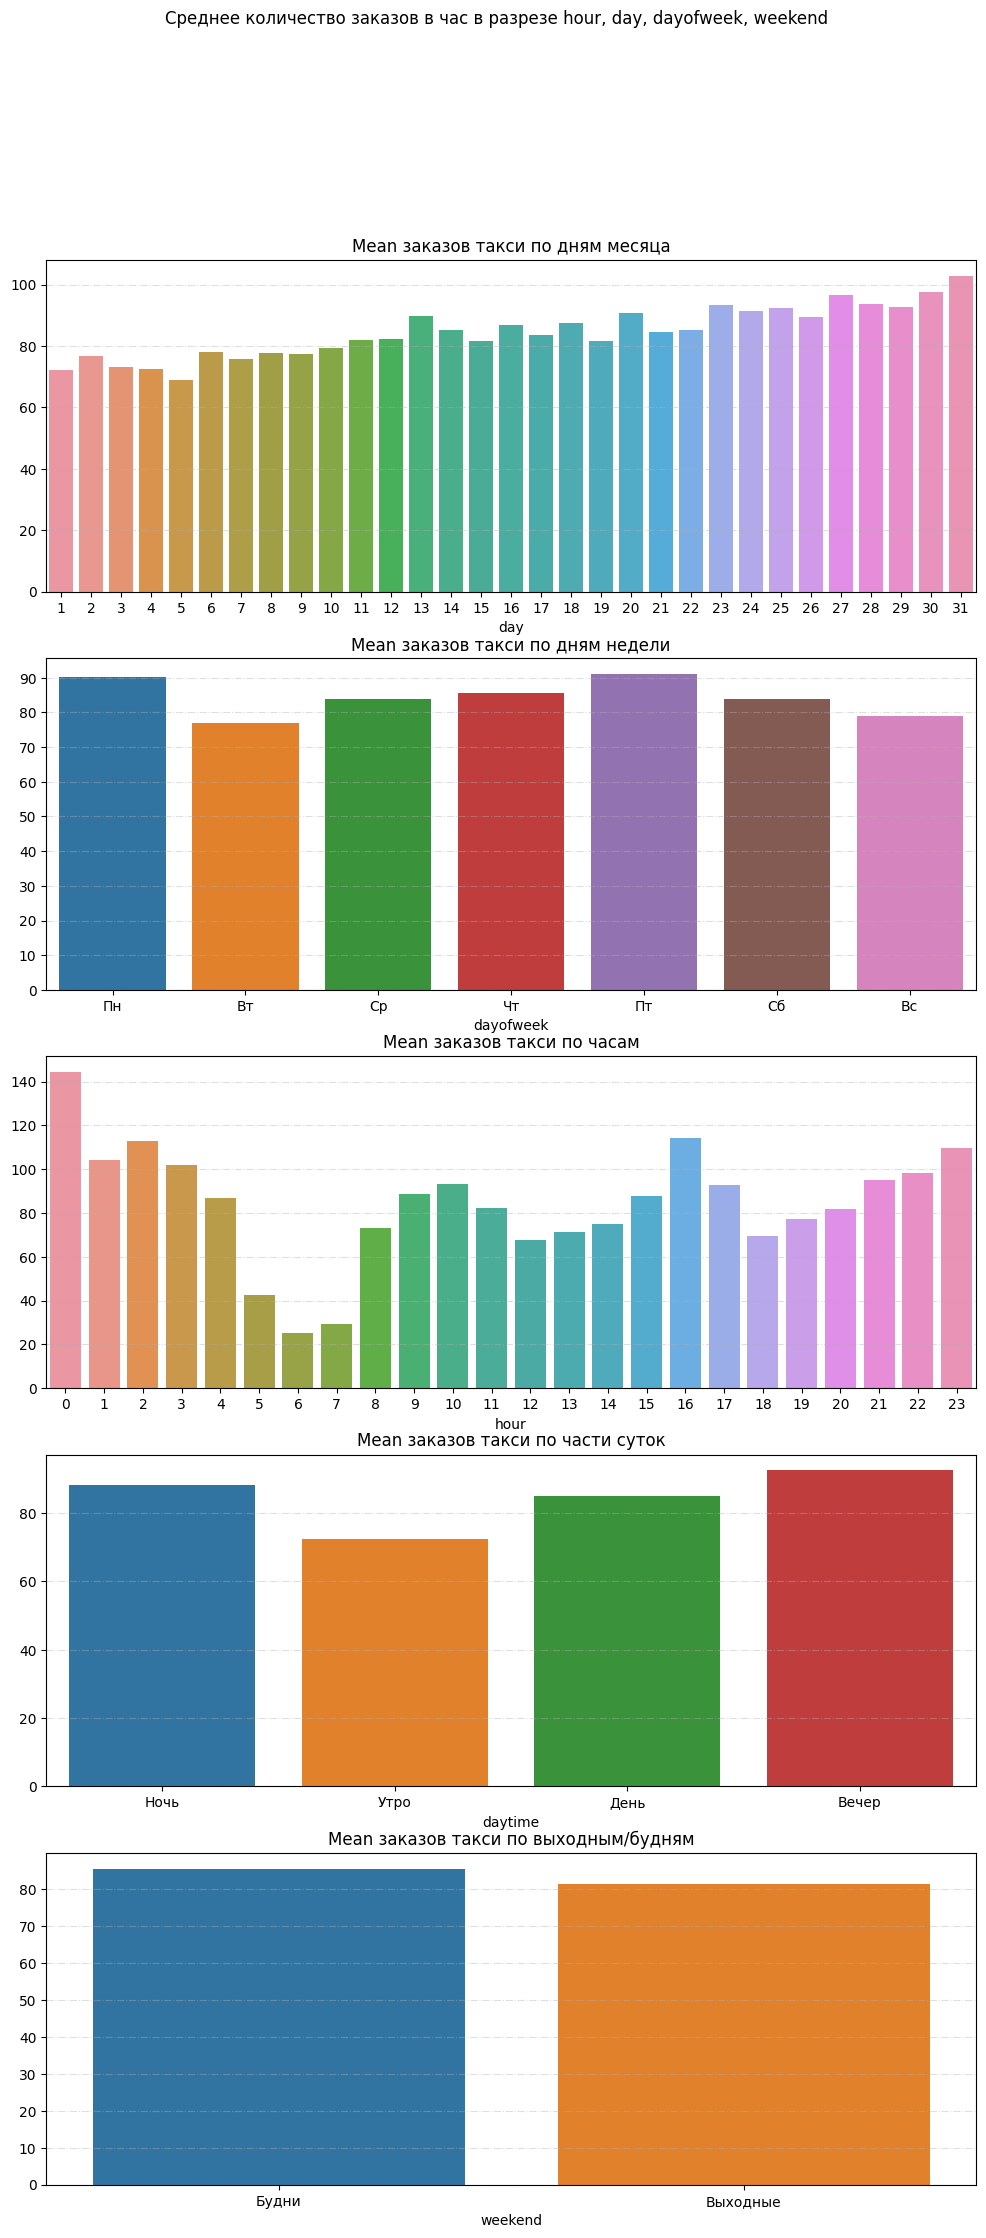

In [62]:
fig, ax = plt.subplots(5, 1, figsize=(12, 25))

def groupby_splitter(data):
    return data.index, data.values

fig.suptitle('Среднее количество заказов в час в разрезе hour, day, dayofweek, weekend')

ax0_x, ax0_y = groupby_splitter(df.groupby('day')['num_orders'].mean())
ax[0].set_title('Mean заказов такси по дням месяца')
sns.barplot(x=ax0_x, y=ax0_y, ax=ax[0])
ax[0].grid(axis='y', alpha=0.4, linestyle='-.')

ax1_x, ax1_y = groupby_splitter(df.groupby('dayofweek')['num_orders'].mean())
ax[1].set_title('Mean заказов такси по дням недели')
sns.barplot(x=ax1_x, y=ax1_y, ax=ax[1])
ax[1].set_xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
ax[1].set_yticks(range(0, 100, 10))
ax[1].grid(axis='y', alpha=0.4, linestyle='-.')

ax2_x, ax2_y = groupby_splitter(df.groupby('hour')['num_orders'].mean())
ax[2].set_title('Mean заказов такси по часам')
sns.barplot(x=ax2_x, y=ax2_y, ax=ax[2])
ax[2].grid(axis='y', alpha=0.4, linestyle='-.')

ax3_x, ax3_y = groupby_splitter(df.groupby('daytime')['num_orders'].mean())
ax[3].set_title('Mean заказов такси по части суток')
sns.barplot(x=ax3_x, y=ax3_y, ax=ax[3])
ax[3].set_xticks(range(4), ['Ночь', 'Утро', 'День', 'Вечер'])
ax[3].grid(axis='y', alpha=0.4, linestyle='-.')

ax4_x, ax4_y = groupby_splitter(df.groupby('weekend')['num_orders'].mean())
ax[4].set_title('Mean заказов такси по выходным/будням')
sns.barplot(x=ax4_x, y=ax4_y, ax=ax[4])
ax[4].set_xticks(range(2), ['Будни', 'Выходные'])
ax[4].grid(axis='y', alpha=0.4, linestyle='-.')

plt.show();

- среднее количество заказов в час растет как и к концу месяца, так и в целом с каждым последующим месяцем
- максимальное среднее количество заказов в час среди дней недели в пятницу и понедельник (перед  выходными и после), минимальное - во вторник.
- максимальное среднее количество заказов в час среди части суток вечером, минимальное - утром
- среднее количество заказов в час в будние дни выше, чем в выходные.  Вероятно, это связано с тем, что понедельник и пятница наиболее популярные дни, и с тем, что многие используют такси для рабочих поездок
- максимальное среднее количество заказов в час в 00 часов, минимальное - в 6 часов утра

Разберём подробнее конец временного промежутка, а именно заказы в августе

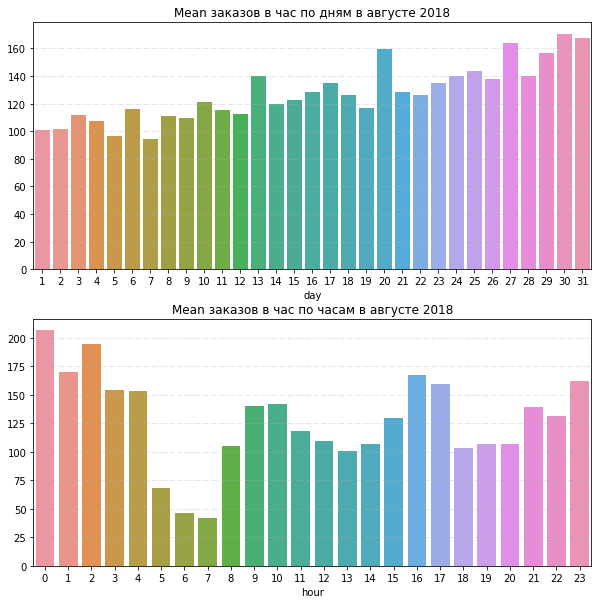

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

def groupby_splitter(data):
    return data.index, data.values

ax0_x, ax0_y = groupby_splitter(df['2018-08':'2018-08'].groupby('day')['num_orders'].mean())
ax[0].set_title('Mean заказов в час по дням в августе 2018')
sns.barplot(x=ax0_x, y=ax0_y, ax=ax[0])
ax[0].grid(axis='y', alpha=0.4, linestyle='-.')

ax1_x, ax1_y = groupby_splitter(df['2018-08':'2018-08'].groupby('hour')['num_orders'].mean())
ax[1].set_title('Mean заказов в час по часам в августе 2018')
sns.barplot(x=ax1_x, y=ax1_y, ax=ax[1])
ax[1].grid(axis='y', alpha=0.4, linestyle='-.')

Мы видим, что пики среднего количества заказов в час в августе были 13, 20, 27 числа - это понедельники. Спады по вторникам и воскресеньям. По времени суток также наиболее популярное дла заказов время - это начало дня - 00 часов, меньше всего заказов с 5 до 7 часов утра

**Выводы**:

- ресемлировали данные по одному часу
- оценили динамику целевого признака - с марта по август количество заказов постеренно увеличивается
- добавили новые признаки с помощью функции make_features
- выявили закономерности на основании графиков - наиболее популярные для заказа такси дни - это понедельник и пятница; вечером и в начале ночи больше заказов, чем утром; будни популярнее выходных
- оценили стационарность временного ряда; ряд - нестационарный (большое влияние оказали колебания последнего месяца)
- рассмотрели присутствующие в данных тренд и сезонность за все время и за последний изучаемый месяц


## Обучение

На обработанных данных будем обучать следующиие модели:

- LinearRegression
- GradientBoostingRegressor
- CatBoostRegressor

Ставим целью найти лучшую для тестирования

По исходным данным создадим обучающую (train) и тестовую (test) выборки с соотношением 90:10 (согласно заданию).

Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего. Функция train_test_split() из модуля sklearn.model_selection по умолчанию перемешивает данные. Поэтому укажем аргумент shuffle равным False, чтобы разделить данные корректно.

Также перед обучением исключим записи с пропусками, которые возникли по причине добавления новых признаков

In [ ]:
df.dropna(inplace=True)

In [ ]:
# создадим признаки
features = df.drop('num_orders', axis=1)
target = df['num_orders']

# создадим обучающую выборку и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.10, shuffle=False)

print(features_train.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_test) / len(df))

(3823, 175)
(425, 175)
0.8999529190207156
0.10004708097928437


Проверим, что данные корректно разделены по хронометражу:

In [ ]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [ ]:
print(sum(features_train.isna().sum()))
print(sum(features_test.isna().sum()))

0
0


**StandardScaler**

Так как будут использоваться в том числе и линейные модели, масштабируем признаки с помощью StandardScaler (признаки числовые)

In [ ]:
scaler = StandardScaler()

scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train),
                              columns=features_train.columns,
                              index=features_train.index)

features_test = pd.DataFrame(scaler.transform(features_test),
                              columns=features_test.columns,
                              index=features_test.index)

print(features_train.head())
print(features_test.head())

                     rolling_mean      hour       day  dayofweek   weekend  \
datetime                                                                     
2018-03-08 00:00:00      0.408365 -1.658183 -0.871206  -0.007568 -0.637206   
2018-03-08 01:00:00      1.072974 -1.513798 -0.871206  -0.007568 -0.637206   
2018-03-08 02:00:00      1.087267 -1.369413 -0.871206  -0.007568 -0.637206   
2018-03-08 03:00:00      0.779974 -1.225027 -0.871206  -0.007568 -0.637206   
2018-03-08 04:00:00      0.358341 -1.080642 -0.871206  -0.007568 -0.637206   

                      daytime  day_orders     lag_1     lag_2     lag_3  ...  \
datetime                                                                 ...   
2018-03-08 00:00:00 -1.234733    0.538840  0.371383  1.220297  0.731578  ...   
2018-03-08 01:00:00 -1.234733    1.082168  1.632878  0.370807  1.220794  ...   
2018-03-08 02:00:00 -1.234733   -1.427487 -0.040533  1.632171  0.371103  ...   
2018-03-08 03:00:00 -1.234733   -0.340832 -0.375215 -

In [ ]:
print(features_train.index.is_monotonic)
print(features_test.index.is_monotonic)

True
True


**LinearRegression**

Зададим RMSE scorer для кросс-валидатора и GridSearchCV

In [ ]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

Будем использовать кросс-валидацию. Поскольку работаем с временным рядом, то в качестве алгоритма проведения кросс-валидации будем использовать TimeSeriesSplit с разбивкой на 5 фолдов

In [ ]:
lr_time = time()

lr_model = LinearRegression()

lr_cv = cross_val_score(lr_model,
                        features_train,
                        target_train,
                        cv=TimeSeriesSplit(n_splits=5),
                        scoring=rmse_scorer, n_jobs=-1)

lr_model.fit(features_train, target_train)

lr_rmse = round(lr_cv.mean(), 2)

lr_full_time = round(time() - lr_time, 2)

print('Cross-val RMSE LinearRegression:', lr_rmse)
print('Time:', lr_full_time)

Cross-val RMSE LinearRegression: 22.61
Time: 2.39


**GradientBoostingRegressor**

In [ ]:
def GS_best_params(model,
                   params_grid,
                   features_train,
                   target_train,
                   scorer=rmse_scorer,
                   cv_rate=8,
                   refit=True,
                   verbose=3,
                   n_jobs=-1):

    GS = GridSearchCV(model,
                      params_grid,
                      cv=TimeSeriesSplit(n_splits=cv_rate),
                      refit=refit,
                      scoring=scorer,
                      verbose=verbose,
                      n_jobs=n_jobs).fit(features_train, target_train)

    return GS

In [ ]:
gbr_time = time()

gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE)

gbr_params = {'n_estimators' : [400, 500],
              'learning_rate' : [0.5],
              'max_depth' : [3, 5]}

gbr_gs = GS_best_params(gbr_model, gbr_params, features_train, target_train)

gbr_est = gbr_gs.best_estimator_

gbr_rmse = round(gbr_gs.best_score_, 2)

gbr_full_time = round(time() - gbr_time, 2)

print('Cross-val RMSE GradientBoostingRegressor:', gbr_rmse)
print('Time:', gbr_full_time)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=   4.8s
[CV 2/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=   9.2s
[CV 3/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  12.9s
[CV 4/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  17.1s
[CV 5/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  21.9s
[CV 6/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  25.3s
[CV 7/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  30.5s
[CV 8/8] END learning_rate=0.5, max_depth=3, n_estimators=400; total time=  34.1s
[CV 1/8] END learning_rate=0.5, max_depth=3, n_estimators=500; total time=   6.1s
[CV 2/8] END learning_rate=0.5, max_depth=3, n_estimators=500; total time=  11.4s
[CV 3/8] END learning_rate=0.5, max_depth=3, n_estimators=500; total time=  16.3s
[CV 4/8] END learning_rate=0.5, max_de

**CatBoostRegressor**

In [ ]:
cbr_time = time()

cbr_model = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

cbr_params = {'iterations': [400, 500],
              'learning_rate': [0.5],
              'depth' : [3, 5]}

cbr_gs = GS_best_params(cbr_model, cbr_params, features_train, target_train)

cbr_est = cbr_gs.best_estimator_

cbr_rmse = round(cbr_gs.best_score_, 2)

cbr_full_time = round(time() - cbr_time, 2)

print('Cross-val RMSE CatBoostRegressor:', cbr_rmse)
print('Time:', cbr_full_time)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.7s
[CV 2/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   2.9s
[CV 3/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   3.3s
[CV 4/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   3.4s
[CV 5/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   3.6s
[CV 6/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   3.8s
[CV 7/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   4.1s
[CV 8/8] END .....depth=3, iterations=400, learning_rate=0.5; total time=   4.1s
[CV 1/8] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.1s
[CV 2/8] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.5s
[CV 3/8] END .....depth=3, iterations=500, learning_rate=0.5; total time=   3.8s
[CV 4/8] END .....depth=3, iterations=500, learni

**Промежуточные результаты обучения моделей**

In [ ]:
model_results = pd.DataFrame({'Model': ['LinearRegression',
                                         'GradientBoostingRegressor',
                                         'CatBoostRegressor'],

                              'Cross-val RMSE': [lr_rmse, gbr_rmse, cbr_rmse],

                              'Time (seconds)': [lr_full_time, gbr_full_time, cbr_full_time]})

model_results = model_results.sort_values(by='Cross-val RMSE')
model_results

,Model,Cross-val RMSE,Time (seconds)
0,LinearRegression,22.61,2.39
2,CatBoostRegressor,25.07,203.95
1,GradientBoostingRegressor,26.04,976.96


**Выводы:**
- абсолютный лидер среди моделей - LinearRegression: лучше результат RMSE и время обучения в разы меньше других моделей. Её и выберем для тестирования

## Тестирование

In [ ]:
best_model = lr_model

model_preds = best_model.predict(features_test)

model_test_rmse = mean_squared_error(target_test, model_preds, squared=False)

print('Model:', best_model)
print('Test RMSE:', round(model_test_rmse, 2))

Model: LinearRegression()
Test RMSE: 34.02


In [ ]:
result = pd.DataFrame([target_test.reset_index()['num_orders'], model_preds]).T
result = result.rename(columns={'num_orders': 'real_values', 'Unnamed 0': 'best_model_predictions'})
result.head()

,real_values,best_model_predictions
0,54.0,42.957879
1,91.0,90.084207
2,135.0,109.735714
3,155.0,125.338742
4,162.0,108.764353


Значение RMSE удовлетворяет минимально допустимому порогу в 48, поэтому модель можно использовать

Визуализируем предсказания

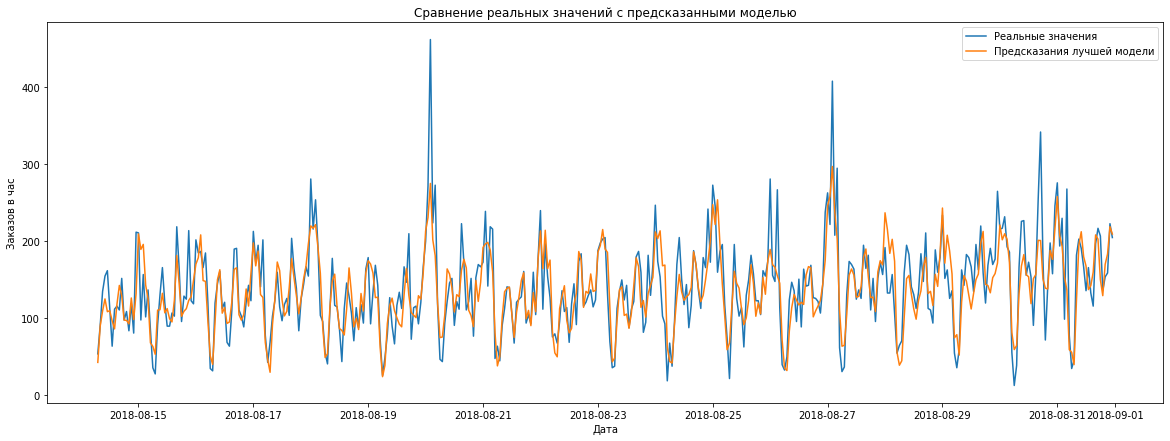

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(target_test.index, target_test)
plt.plot(features_test.index, model_preds)

plt.title('Сравнение реальных значений с предсказанными моделью')
plt.xlabel('Дата')
plt.ylabel('Заказов в час')
plt.legend(['Реальные значения', 'Предсказания лучшей модели'])

- в целом модель учла колебания по дням недели, по времени суток и неплохо предсказывает периоды повышенного спроса
- как видно, модель хуже предсказывает пиковые значения. Мы видим, что некоторые максимальные пиковые по количеству заказов периоды модель обрабатывает чуть занижая количество требуемых автомобилей, но все же это лучше, чем завышение количества

Результат не идеальный, но под требования заказчика попадает (к тому же, работает она очень быстро). Следовательно, модель можно использовать, в чем мы убежадаемся во второй раз после визуального подтверждения требуемого качества модели.

**Проверка на адекватность**

Сравним нашу модель с предсказанием значений тестовой выборки одним и тем же числом (константой) и значениями ряда x(t), спрогнозированными на предыдущих значениях, то есть x(t-1)

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
print('Среднее количество заказов в час:', round(test['num_orders'].mean(), 2))
pred_median = np.ones(test.shape) * test['num_orders'].median()
print('RMSE:', round(mean_squared_error(test, pred_median, squared=False), 2))

Среднее количество заказов в час: 140.09
RMSE: 59.3


In [ ]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print('RMSE:', round(mean_squared_error(test, pred_previous, squared=False), 2))

RMSE: 55.13


Наша модель прошла проверки на адекватность

- лучшей была выбрана модель LinearRegression
- модель прошла проверку на адекватность
- значение RMSE на тестовой выборке составило 46.81

**Итоговые выводы:**

Для компании "Чётенькое такси" была разработана модель машинного обучения для предсказания количества заказов такси в следующий час. Требовалось получить модель, которая на тестовой выборке покажет значение метрики RMSE менее 48 - этого удалось достигнуть.

*Итого основные результаты по шагам проекта:*

- подготовка данных
  - импортированы необходимые библиотеки и загружены данные
  - осуществлен ресемплинг данных

- анализ данных
  - рассмотрены и визуализированы временные зависимости в данных (максимальное среднее количество заказов в час среди дней недели в пятницу и понедельник (перед  выходными и после), минимальное - во вторник. Будни популярнее выходных. Наиболее популярное для заказа такси время - близкое к полуночи, наименее популярное - в 6 часов утра)
  - проанализировано скользящее среднее, определен вид временного ряда - нестационарный
  - исследованы тренды и сезонности в данных, определили, что существуют суточная и недельная сезонности
  - добавлены дополнительные признаки

- обучение моделей
  - данные согласно заданию были разделены на тренировочную и тестовую выборки (90/10)
  - выполнена стандартизация признаков с помощью StandardScaler
  - обучены модели, подобраны гиперпараметры, подготовлена итоговая сводная таблица с результатами
  - лучшей была выбрана модель LinearRegression()


| Модель                        | Значение RMSE на кросс-валидации/GridSearchCV | Время обучения (сек) |
|-------------------------------|-----------------------------------------------|-----------------------------|
| LinearRegression               | 22.61                                      | 2.39                      |
| CatBoostRegressor | 25.07                                      | 203.95                      |
| GradientBoostingRegressor                | 26.04 | 976.96                     |

- тестирование модели
  - значение RMSE на тестовом наборе данных составило 34.02, что соответствует критерию заказчика